# Getting started with *uproot4*

In this notebook, we will see how ROOT files can be viewed using [uproot4](https://github.com/scikit-hep/uproot4) python package. 

More help on how to use the package can be found in https://uproot.readthedocs.io/en/latest/index.html. Here we will give a few simple examples that will be used during the project.

If needed, install the package using:
```
!python -m pip install uproot4
```


In [1]:
#import uproot
import uproot4

Explore the content of the file:

In [2]:
# relace next line with the path to your file
#path='data'
path='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2022/'
filename=path+'/delphes_GammaGammaMuMu_FPMC_pT25_14TeV_10kEvents.root'

In [3]:
#open the file, using uproot
root_=uproot4.open( filename )

Now inspect the conten of the file:

In [4]:
root_.keys()

['ProcessID0;1', 'Delphes;1']

In the selected file, we have a tree named `Delphes`, let's get the tree and see the branches:

In [5]:
tree_ = root_["Delphes"]

In [6]:
tree_.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | TClonesArray             | AsGroup(<TBranchElement 'Ev...
Event/Event.fUniq... | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.fBits    | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.Number   | int64_t[]                | AsJagged(AsDtype('>i8'))
Event/Event.ReadTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.ProcTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Proce... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.MPI      | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Weight   | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/E

A shorter option to read a tree from a file is:
```
tree_ = uproot4.open(filename+":Delphes")
```

To see the content of a single variable (we will see the number of verteces in each event):

In [7]:
vtx_size = tree_['Vertex_size'].array()
print(vtx_size)

[201, 201, 175, 209, 195, 220, 180, 195, ... 187, 226, 204, 220, 190, 194, 204, 207]


## Convert ROOT to pandas dataframe

export the ROOT file content into pandas dataframe:

The tricky part is that in ROOT files we usually store vectors, and the conversion to dataframes is not always trivial. The simplest way is to store different types of vectors in different dataframes:

In [8]:
#variables_to_save=[tree_.keys()] # this will not work, due to vectors in the dataset
muons_df = tree_.arrays(['Muon_size','Muon.PT','Muon.Eta','Muon.Phi'], library="pd")
genproton_df = tree_.arrays(['GenProton_size','GenProton.Pz','GenProton.Z','GenProton.IsPU'], library="pd")
floats_df = tree_.arrays(['GenProton.T'], library="pd")

In [9]:
muons_df.head()

Muon_size    Muon.PT  Muon.Eta  Muon.Phi
entry subentry                                          
0     0                 5  31.022085 -0.149884  2.231742
      1                 5  30.599255 -1.406541 -0.917143
      2                 5   1.644967 -2.805224  1.883558
      3                 5   0.267687 -3.649903  0.101727
      4                 5   0.246806 -3.483779 -2.653385

In [10]:
genproton_df.head()

GenProton_size  GenProton.Pz  GenProton.Z  GenProton.IsPU
entry subentry                                                           
0     0                    577   6982.961914     4.232870               0
      1                    577  -6918.951172     4.232870               0
      2                    577   6999.997070    35.910526               1
      3                    577    -35.066551    14.159362               1
      4                    577      0.141398    14.159362               1

In [11]:
floats_df.head()

GenProton.T
entry subentry              
0     0        -1.330776e-10
      1        -1.330776e-10
      2        -9.188213e-12
      3        -1.755335e-11
      4        -1.755335e-11

### analyze the tree

Now let's do a simple analysis, we will compute invariant of pair of signal protons, and compare it to the invariant mass of two muons with highest $p_T$:

Muon kinematics are vectors, and the easy way is to process tree, and create floats for each event and store them in the dataframe.

In [12]:
import pandas as pd
import numpy as np

create new arrays:

In [13]:
n_events = len(vtx_size)
mpp=np.zeros(n_events)
mll=np.zeros(n_events)

### Read proton content

Since the example file contains all protons (forward and central), we will select protons with transverse momentum within the PPS acceptance. The PPS acceptance used here can be found in Table 4 of [The CMS Precision Proton Spectrometer at the HL-LHC - Expression of Interest](https://cds.cern.ch/record/2750358/files/NOTE2020_008.pdf) assuming vertical crossing-angle and farthermost station at 234 m from the interaction point.

In [14]:
#xi acceptance from Table 4 on page 40 of https://cds.cern.ch/record/2750358/files/NOTE2020_008.pdf
xi_min = 0.0095 # using the 234m station
xi_max = 0.1967 # using the 196m station
pz_min = (1-xi_max)*7000
pz_max = (1-xi_min)*7000
print('for xi range of (%2.3f,%2.3f) proton pz is in range from %2.2f to %2.2f GeV'%(xi_min,xi_max,pz_min,pz_max))

for xi range of (0.009,0.197) proton pz is in range from 5623.10 to 6933.50 GeV


In [15]:
#read protons only within the PPS acceptance
protons = tree_.arrays(['GenProton.Pz','GenProton.Z','GenProton.IsPU'],  cut="(abs(GenProton.Pz)>%g) & (abs(GenProton.Pz)<%g)"%(pz_min,pz_max))

In [16]:
N_protons=np.zeros(len(protons)).astype(int)
genproton_pz=protons['GenProton.Pz']
genproton_vz=protons['GenProton.Z']
genproton_ispu=protons['GenProton.IsPU']
genproton_xi=1-np.abs(genproton_pz)/7000
for i, pz in enumerate(protons['GenProton.Pz']):
    N_protons[i] = len(pz)

compute mass of two signal protons

In [17]:
for ev, nprotons in enumerate(N_protons):
    xi_pos=0; xi_neg=0; n_protons=0
    for i in range(nprotons):
        if genproton_ispu[ev][i]: continue
        n_protons=n_protons+1
        if genproton_pz[ev][i] > 0: xi_pos=genproton_xi[ev][i]
        else: xi_neg=genproton_xi[ev][i]
    if n_protons != 2: 
        #print('Error, find '+str(n_protons)+' signal protons, skip')
        mpp[ev]=-1.
    mpp[ev]=14000.*np.sqrt(xi_pos*xi_neg)


In [18]:
# print number of events with two accepted signal protons:
print('Fraction of events with two signal protons = %2.2f%%'%((sum(mpp>0) / n_events)*100))

Fraction of events with two signal protons = 3.45%


### read muon content:

We will read all muons and only tight muons (which is a sub-sample of all muons with tighter identification criteria)

In [19]:
muons = tree_.arrays(['Muon.PT','Muon.Eta','Muon.Phi'],  cut="(Muon.PT>20)")
tight_muons = tree_.arrays(['MuonTight.PT','MuonTight.Eta','MuonTight.Phi'], cut="(MuonTight.PT>20)")

In [20]:
N_muons=np.zeros(len(muons)).astype(int)
mu_pt=muons['Muon.PT']
mu_eta=muons['Muon.Eta']
mu_phi=muons['Muon.Phi']
for i, pt in enumerate(muons['Muon.PT']):
    N_muons[i] = len(pt)

compute invariant mass of peir of leptons:

In [21]:
for ev, nmuons in enumerate(N_muons):
    mu1_pt=0; mu1_eta=0; mu1_phi=0
    mu2_pt=0; mu2_eta=0; mu2_phi=0
    for i in range(nmuons):
        if mu_pt[ev][i]>mu1_pt:
            mu2_pt=mu1_pt
            mu2_eta=mu1_eta
            mu2_phi=mu1_phi
            
            mu1_pt=mu_pt[ev][i]
            mu1_eta=mu_eta[ev][i]
            mu1_phi=mu_phi[ev][i]
        elif mu_pt[ev][i]>mu2_pt:
            mu2_pt=mu_pt[ev][i]
            mu2_eta=mu_eta[ev][i]
            mu2_phi=mu_phi[ev][i]            
    
    # compute invariant mass of lepton pair
    sumE=mu1_pt*np.cosh(mu1_eta)+mu2_pt*np.cosh(mu2_eta)
    sumPx=mu1_pt*np.cos(mu1_phi)+mu2_pt*np.cos(mu2_phi)
    sumPy=mu1_pt*np.sin(mu1_phi)+mu2_pt*np.sin(mu2_phi)
    sumPz=mu1_pt*np.sinh(mu1_eta)+mu2_pt*np.sinh(mu2_eta)
    
    
    mll2 = sumE**2 - sumPx**2 - sumPy**2 - sumPz**2
    if(mll2<0): mll2=0
    mll[ev]=np.sqrt(mll2)

    

To end this exersize, plot the correlation between $m_{ll}$ and $m_{pp}$

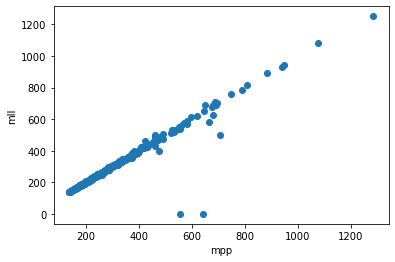

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(mpp[mpp>0], mll[mpp>0])
plt.xlabel("mpp")
plt.ylabel("mll")
plt.show()